In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_squared_error
import numpy as np

from sklearn.metrics import r2_score

In [2]:
train_df = pd.read_csv("Data/train.csv")
test_df = pd.read_csv("Data/test.csv")

In [3]:
missing_values_train = train_df.isnull().sum() / len(train_df) * 100
missing_values_test = test_df.isnull().sum() / len(test_df) * 100

cols_to_drop = set(missing_values_train[missing_values_train > 50].index)
cols_to_drop.update({'Id', 'LandContour', 'LotConfig', 'LotFrontage', 'Street', 'LotShape', 'LandSlope', 'YearBuilt', 'RoofStyle', 'RoofMatl', 
                     'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                     'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 
                     'Electrical', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                     'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageCars', 'PavedDrive', 'WoodDeckSF', 
                     '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'SaleType', 'SaleCondition', 'Condition1', 'Condition2','HouseStyle'})

train_df.drop(columns=cols_to_drop, inplace=True)

cols_to_drop = set(missing_values_test[missing_values_test > 50].index)
cols_to_drop.update({'Id', 'LandContour', 'LotConfig', 'LotFrontage', 'Street', 'LotShape', 'LandSlope', 'YearBuilt', 'RoofStyle', 'RoofMatl', 
                     'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                     'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 
                     'Electrical', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                     'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageCars', 'PavedDrive', 'WoodDeckSF', 
                     '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'SaleType', 'SaleCondition', 'Condition1', 'Condition2','HouseStyle'})

test_df.drop(columns=cols_to_drop, inplace=True)

def encode_quality_df(df):
    # Funkcja zamienia wartości jakościowe na liczby w całym DataFrame.
    mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0, 
               'AllPub': 3, 'NoSewr': 2, 'NoSeWa': 1, 'ELO': 0, 
               'N': 0, 'Y': 1, 'Fin': 3, 'RFn': 2, 'Unf': 1, 
               'Typ': 5, 'Min1': 4, 'Min2': 4, 'Mod': 3, 'Maj1': 2, 'Maj2': 2, 'Sev': 1, 'Sal': 0}
    return df.replace(mapping).fillna(0)
    

ms_subclass_mapping = {
    20: "1-STORY 1946 & NEWER ALL STYLES",
    30: "1-STORY 1945 & OLDER",
    40: "1-STORY W/FINISHED ATTIC ALL AGES",
    45: "1-1/2 STORY - UNFINISHED ALL AGES",
    50: "1-1/2 STORY FINISHED ALL AGES",
    60: "2-STORY 1946 & NEWER",
    70: "2-STORY 1945 & OLDER",
    75: "2-1/2 STORY ALL AGES",
    80: "SPLIT OR MULTI-LEVEL",
    85: "SPLIT FOYER",
    90: "DUPLEX - ALL STYLES AND AGES",
    120: "1-STORY PUD (Planned Unit Development) - 1946 & NEWER",
    150: "1-1/2 STORY PUD - ALL AGES",
    160: "2-STORY PUD - 1946 & NEWER",
    180: "PUD - MULTILEVEL - INCL SPLIT LEV/FOYER",
    190: "2 FAMILY CONVERSION - ALL STYLES AND AGES"
}
train_df["MSSubClass"] = train_df["MSSubClass"].map(ms_subclass_mapping)
test_df["MSSubClass"] = test_df["MSSubClass"].map(ms_subclass_mapping)

# print("Usunięte kolumny: ", list(cols_to_drop))
train_df = encode_quality_df(train_df)
train_df = pd.get_dummies(train_df, columns=['MSZoning'], dtype=int)
train_df = pd.get_dummies(train_df, columns=['BldgType'], dtype=int)
train_df = pd.get_dummies(train_df, columns=['Neighborhood'], dtype=int)
train_df = pd.get_dummies(train_df, columns=['MSSubClass'], dtype=int)

test_df = encode_quality_df(test_df)
test_df = pd.get_dummies(test_df, columns=['MSZoning'], dtype=int)
test_df = pd.get_dummies(test_df, columns=['BldgType'], dtype=int)
test_df = pd.get_dummies(test_df, columns=['Neighborhood'], dtype=int)
test_df = pd.get_dummies(test_df, columns=['MSSubClass'], dtype=int)

# Po get_dummies na train_df i test_df
train_columns = train_df.columns
test_df = test_df.reindex(columns=train_columns, fill_value=0)


target_col = 'SalePrice'
x = train_df.drop(columns=[target_col])
y = train_df[target_col]

scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
x_test = pd.DataFrame(scaler.transform(test_df.drop(columns=[target_col], errors='ignore')), columns=x.columns)





C:\Users\zboro\AppData\Local\Temp\ipykernel_16464\789871874.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.replace(mapping).fillna(0)
C:\Users\zboro\AppData\Local\Temp\ipykernel_16464\789871874.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.replace(mapping).fillna(0)


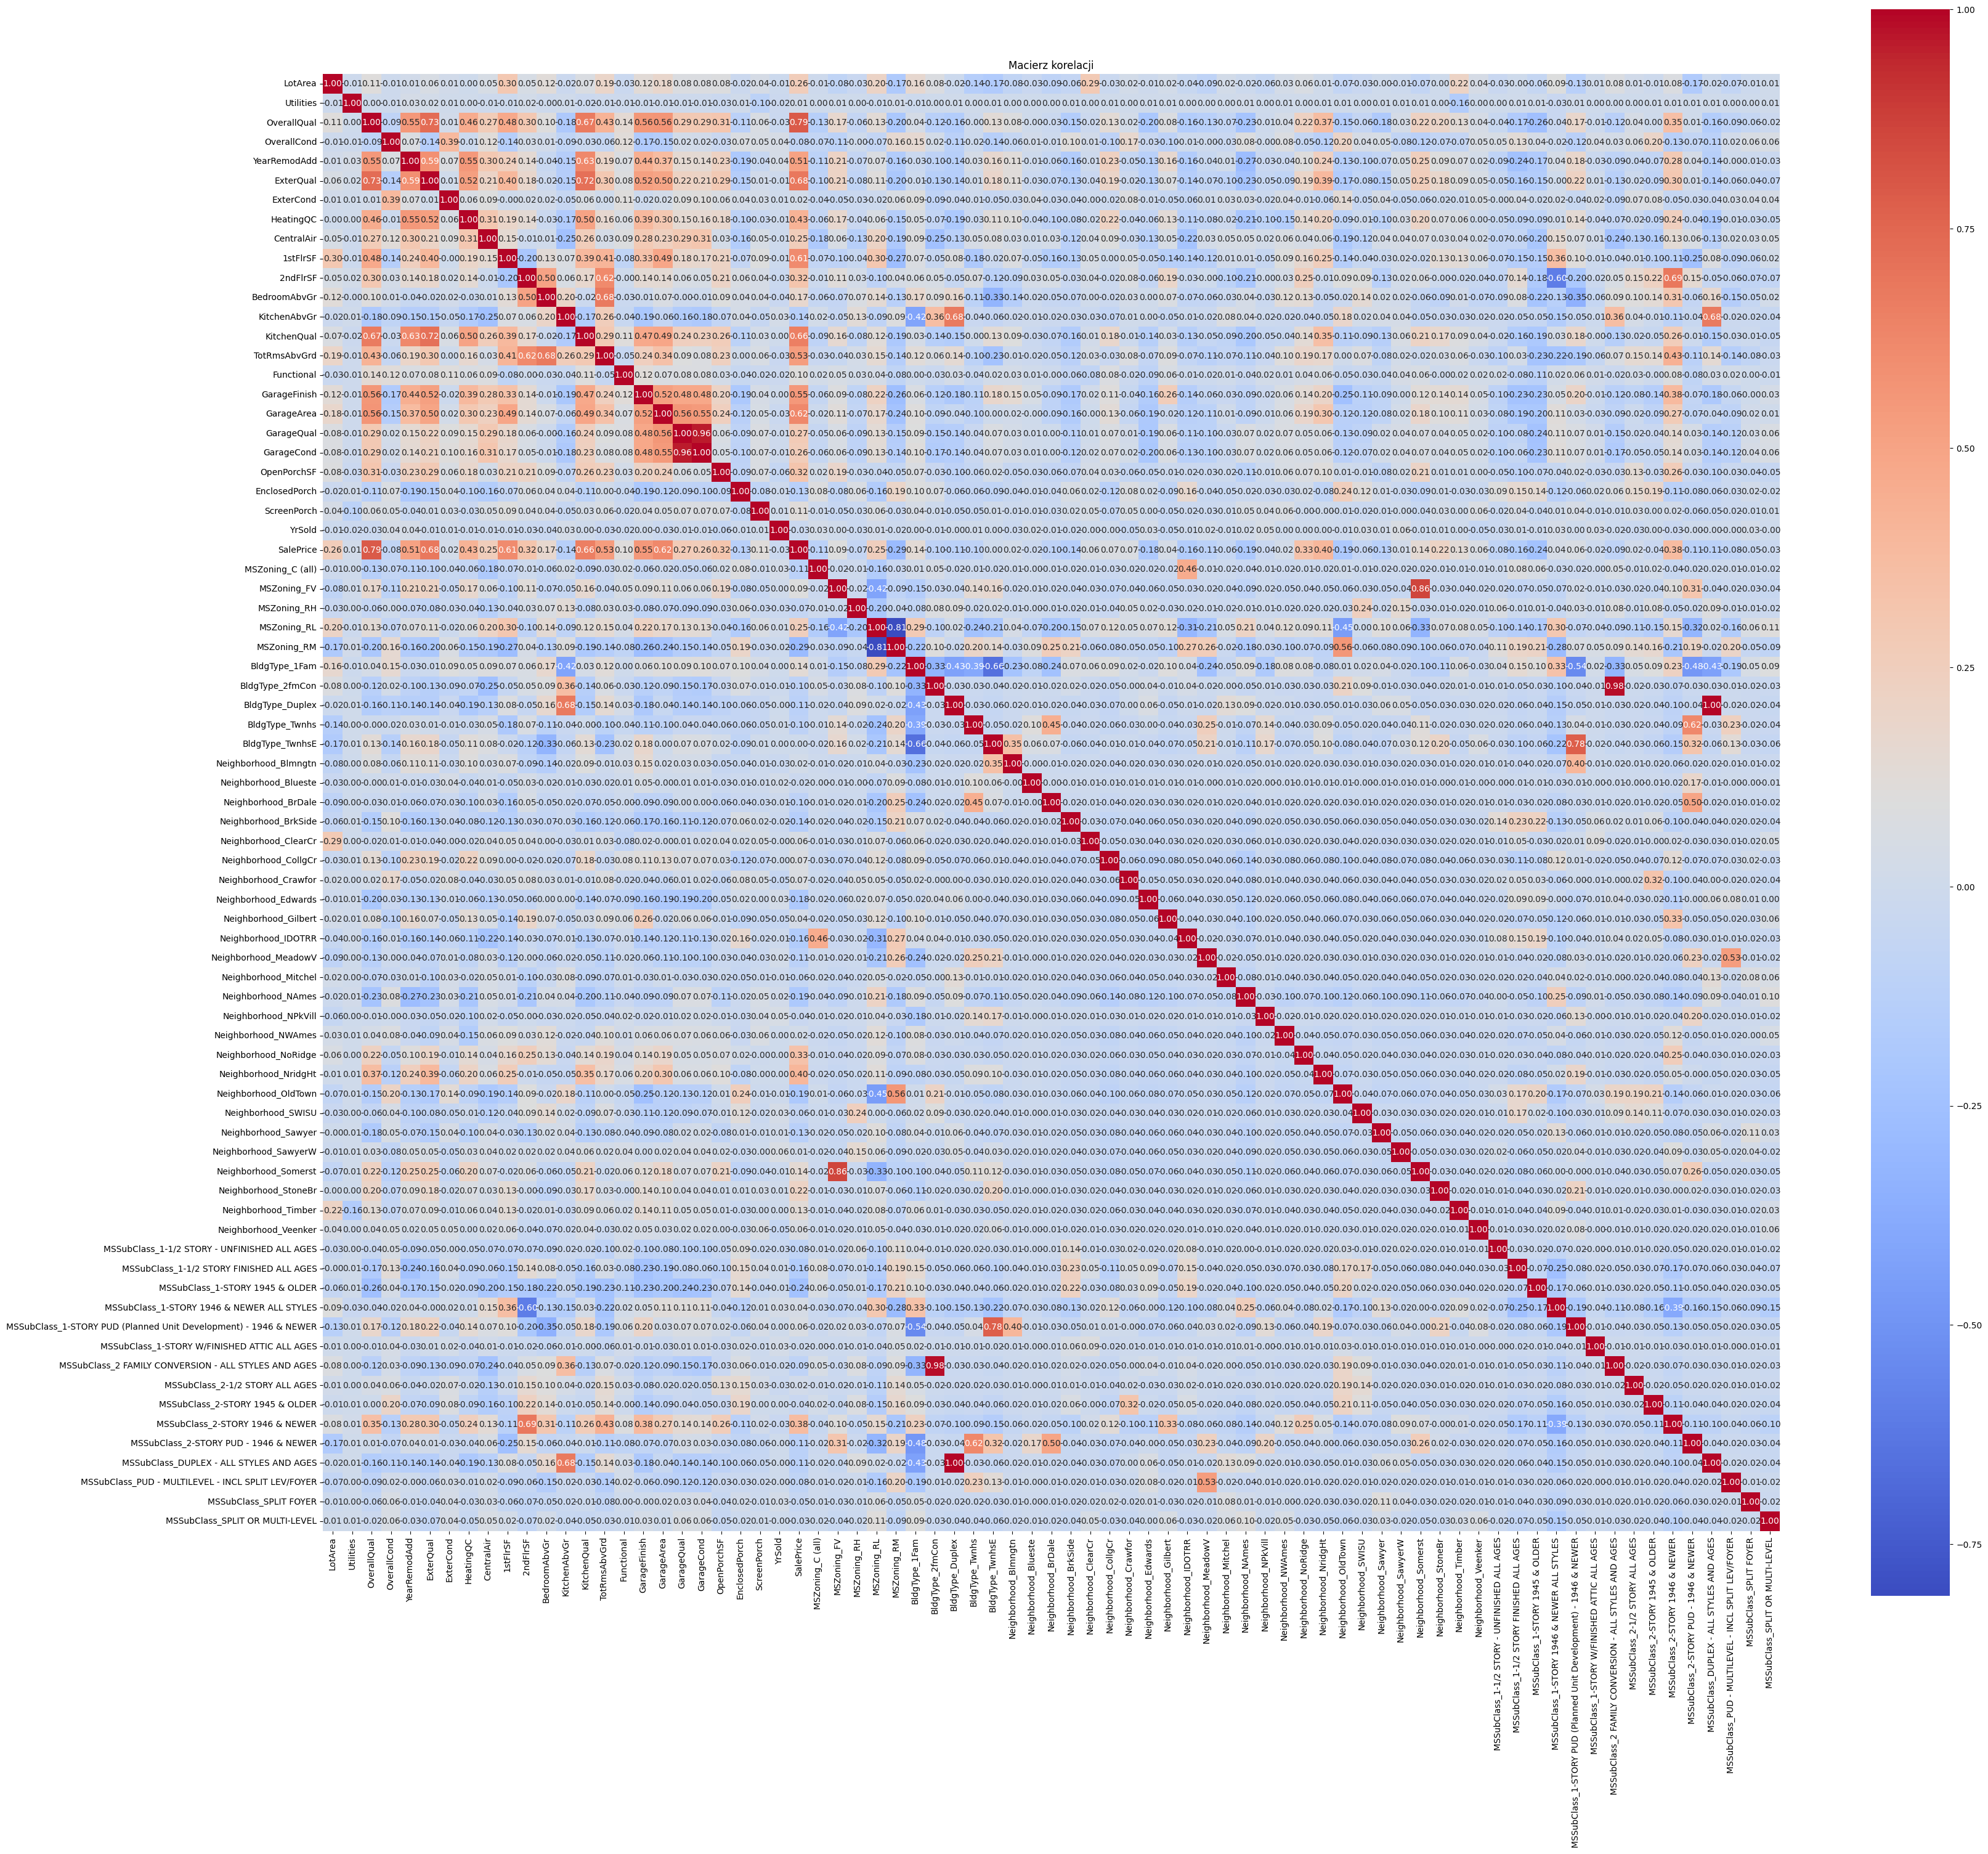

                                                     LotArea  Utilities  \
LotArea                                             1.000000  -0.010123   
Utilities                                          -0.010123   1.000000   
OverallQual                                         0.105806   0.001881   
OverallCond                                        -0.005636  -0.009994   
YearRemodAdd                                        0.013788   0.034080   
...                                                      ...        ...   
MSSubClass_2-STORY PUD - 1946 & NEWER              -0.166381   0.005560   
MSSubClass_DUPLEX - ALL STYLES AND AGES            -0.015346   0.005031   
MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER -0.068826   0.002174   
MSSubClass_SPLIT FOYER                             -0.014166   0.003085   
MSSubClass_SPLIT OR MULTI-LEVEL                     0.007719   0.005325   

                                                    OverallQual  OverallCond  \
LotArea            

In [4]:
corr_matrix = train_df.corr()

plt.figure(figsize=(35, 35))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Macierz korelacji')
plt.tight_layout()
plt.show()
print(corr_matrix)

In [5]:
print(x_train)
print(x_test)

       LotArea  Utilities  OverallQual  OverallCond  YearRemodAdd  ExterQual  \
0     0.033420        1.0     0.666667        0.500      0.883333   0.666667   
1     0.038795        1.0     0.555556        0.875      0.433333   0.333333   
2     0.046507        1.0     0.666667        0.500      0.866667   0.666667   
3     0.038561        1.0     0.666667        0.500      0.333333   0.333333   
4     0.060576        1.0     0.777778        0.500      0.833333   0.666667   
...        ...        ...          ...          ...           ...        ...   
1455  0.030929        1.0     0.555556        0.500      0.833333   0.333333   
1456  0.055505        1.0     0.555556        0.625      0.633333   0.333333   
1457  0.036187        1.0     0.666667        1.000      0.933333   1.000000   
1458  0.039342        1.0     0.444444        0.625      0.766667   0.333333   
1459  0.040370        1.0     0.444444        0.625      0.250000   0.666667   

      ExterCond  HeatingQC  CentralAir 

In [6]:
# Zamień dane na tensory
x = torch.tensor(x_train.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)  # view(-1, 1) żeby mieć kolumnę

# Podziel dane na zestaw treningowy i walidacyjny (opcjonalnie)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=0)

# Zrób DataLoader'y
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [7]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.net(x)

# Utwórz model
input_dim = x.shape[1]  # liczba kolumn w x
model = RegressionModel(input_dim)


In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.004)

In [9]:
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Ewaluacja na walidacji
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_outputs = model(val_X)
            v_loss = criterion(val_outputs, val_y)
            val_loss += v_loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


Epoch 1/1000, Train Loss: 38924232925.4054, Val Loss: 43735326924.8000
Epoch 2/1000, Train Loss: 38217628146.1622, Val Loss: 42564889395.2000
Epoch 3/1000, Train Loss: 36033534782.2703, Val Loss: 38077261209.6000
Epoch 4/1000, Train Loss: 29414203447.3514, Val Loss: 28683436032.0000
Epoch 5/1000, Train Loss: 18623836464.4324, Val Loss: 16851715584.0000
Epoch 6/1000, Train Loss: 8704136392.6486, Val Loss: 8844640793.6000
Epoch 7/1000, Train Loss: 4595125531.6757, Val Loss: 6717072076.8000
Epoch 8/1000, Train Loss: 3929048510.2703, Val Loss: 6363453465.6000
Epoch 9/1000, Train Loss: 3667929423.5676, Val Loss: 6179334067.2000
Epoch 10/1000, Train Loss: 3600826949.1892, Val Loss: 6002561088.0000
Epoch 11/1000, Train Loss: 3448404524.9730, Val Loss: 5851008665.6000
Epoch 12/1000, Train Loss: 3261384015.5676, Val Loss: 5706323571.2000
Epoch 13/1000, Train Loss: 3158733927.7838, Val Loss: 5558713472.0000
Epoch 14/1000, Train Loss: 3053537861.1892, Val Loss: 5447221580.8000
Epoch 15/1000, Trai

In [10]:
model.eval()
with torch.no_grad():
    test_preds = model(torch.tensor(x_test.values, dtype=torch.float32))



In [11]:
# Włącz tryb oceny modelu
model.eval()

# Przewidywanie na danych walidacyjnych
with torch.no_grad():
    val_preds = model(X_val)

# Oblicz MSE (Mean Squared Error)
mse = mean_squared_error(y_val.numpy(), val_preds.numpy())

# Oblicz RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

r2 = r2_score(y_val.numpy(), val_preds.numpy())

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 1130197248.0000
Root Mean Squared Error (RMSE): 33618.4064
R² Score: 0.8363


In [12]:
# Use the original test data to retrieve the 'Id' column
original_test_df = pd.read_csv("Data/test.csv")  # Reload the original test data to get the 'Id' column

submission_df = pd.DataFrame({
    'Id': original_test_df['Id'],  # Use the 'Id' column from the original test data
    'SalePrice': test_preds.flatten()
})

submission_df.to_csv('submission.csv', index=False)





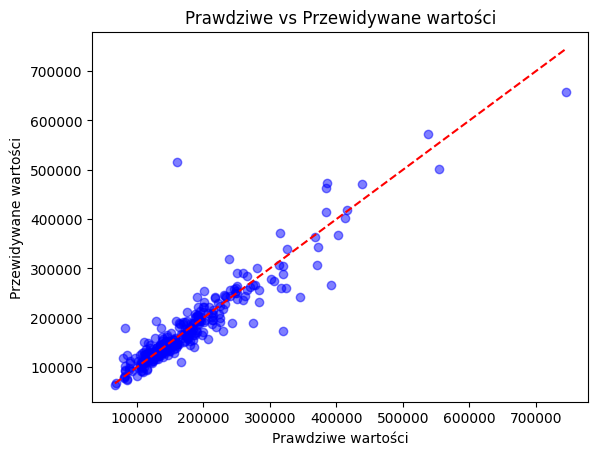

In [13]:
# Tworzenie wykresu
plt.scatter(y_val.numpy(), val_preds.numpy(), color='blue', alpha=0.5)
plt.plot([min(y_val.numpy()), max(y_val.numpy())], [min(y_val.numpy()), max(y_val.numpy())], color='red', linestyle='--')
plt.xlabel("Prawdziwe wartości")
plt.ylabel("Przewidywane wartości")
plt.title("Prawdziwe vs Przewidywane wartości")
plt.show()